In [ ]:
!pwd
! echo "foooo" > ./drive/MyDrive/titi

In [ ]:
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import random
import math
import pickle
import gzip


In [1]:
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import random
import math
import pickle
import gzip

The goal is to set up a simple classifier for text and sentiment analysis. 

The goal of this lab session is to implement the model proposed by  Yoon Kim, published in 2014. This model is a sentence classifier based on Convolution. The original paper can be found [here](https://www.aclweb.org/anthology/D14-1181). It was then adapted to DNA sequence classification by [this paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-017-1878-3). Of course, there exists pytorch and tensorflow implementations on the web. They are more or less correct and efficient. However, here it is important to do it yourself. The goal is to better understand pytorch and the convolution. 

The task is the binary classification of movie reviews. The dataset is a part of the imdb dataset. You can find the original dataset on the imdb website or a version on the kaggle website. For this lab session, we will use a preprocessed and reduced version. 

The road-map is to: 
- Load the data
- step-by-step computation (debug)
- Create a model to wrap the convolution and pooling 



# Data loading 


Load the data : 

In [ ]:
# find the file imdb.pck.gz, and set the next variable accordingly
filename = 'imdb.pck.gz'

# if you are on colab (otherwise comment the next command): 
# you can download the file with the following line: 
! wget "https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA" -O imdb.pck.gz



fp = gzip.open(filename,'rb')
texts , labels, lexicon  = pickle.load(fp) 

print(type(texts), type(labels), type(lexicon))
print(texts[0])
print("nb examples : ", len(texts))
VOCAB_SIZE = len(lexicon)
print("Vocab size: ", VOCAB_SIZE)


In [3]:
# find the file imdb.pck.gz, and set the next variable accordingly
filename = 'imdb.pck.gz'

# if you are on colab (otherwise comment the next command):
# you can download the file with the following line:
! wget "https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA" -O imdb.pck.gz

fp = gzip.open(filename, 'rb')
texts, labels, lexicon = pickle.load(fp)

print(type(texts), type(labels), type(lexicon))
print(texts[0])
print("no examples : ", len(texts)) #"nb examples : ", len(texts))
VOCAB_SIZE = len(lexicon)
print("Vocab size: ", VOCAB_SIZE)

--2022-04-06 13:34:59--  https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA
Resolving drive.google.com (drive.google.com)... 142.250.148.102, 142.250.148.139, 142.250.148.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.148.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sb8vnick3f5ldqbbcv1kntltnghhf0up/1649252100000/16692574002775380562/*/1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA?e=download [following]
--2022-04-06 13:35:00--  https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sb8vnick3f5ldqbbcv1kntltnghhf0up/1649252100000/16692574002775380562/*/1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA?e=download
Resolving doc-0k-0o-docs.googleusercontent.com (doc-0k-0o-docs.googleusercontent.com)... 142.250.148.132, 2607:f8b0:4001:c54::84
Connecting to doc-0k-0o-docs.googleusercontent.com (doc-0k-0o

You get 3 objects : 
- *texts*  : a list of tensors, each tensor represent a word sequence to classify. 
- *labels* : the class, positive or negative, of the corresponding text
- *lexicon*: a dictionnary to map integers to real words
Note that a reduced number of words are selected to build the vocabulary. The less frequent words are discarded are replaced by a specific form (*unk* for unknown)
To read the text you can use for example the following code: 

In [ ]:
def idx2wordlist(idx_array,lexicon): 
    l = []
    for i in idx_array: 
        l.append(lexicon[i.item()])
    return l
print(texts[0].shape)
for i in range(5): 
    print(idx2wordlist(texts[i+50],lexicon))
print("------------")
for i in range(5): 
    print(idx2wordlist(texts[-i-2000],lexicon))
    


In [4]:
def idx2wordlist(idx_array,lexicon):
  l = []
  for i in idx_array:
    l.append(lexicon[i.item()])
  return l
print(texts[0].shape)
for i in range(5):
  print(idx2wordlist(texts[i+50], lexicon))
print("------------")
for i in range(5):
  print(idx2wordlist(texts[-i-2000], lexicon))

torch.Size([7])
['strong', 'drama']
['please', 'remake', 'this', 'movie']
['very', 'funny', '!']
['great', 'series']
['fun', 'movie']
------------
['absolute', 'waste', 'of', 'time']
['the', 'worst', 'movie', 'ever', 'made']
['slow', 'motion', 'picture', 'that', 'did', "n't", 'get', 'to', 'the', 'point']
['there', 'are', 'good', 'bad', 'movies', 'and', 'there', 'are', 'bad', 'bad', 'movies', 'this', 'one', 'is', 'a', 'real', 'stinker']
['<unk>', 'so', 'bad', 'its', 'funny']


# Embeddings and Convolution layers

Unfortunately, an important part of the work is dedicated to playing with dimensions. This is true for pytorch, as well as tensorflow. Here the sequence of operation is 
- Embedding
- Convolution (1D)
- Pooling
- Linear

Moreover, things can be tricky if we want our model to work properly with mini-batch. 


A quick introduction on  the Embedding layer. The goal is to store a set of real vectors associated to each symbol (word) in the vocabulary. The layer requires : 
- num_embeddings: the vocabulary size or the number of words under consideration. Words are represented by an index (starting at 0)
- embedding_dim : the dimension of the continous space (or the word embeddings. 
Implicitely a lookup matrix is created to store *num_embeddings* of *size embedding_dim*


In [ ]:
vocabSize = len(lexicon)
h1 = 4 # dimension of embeddings, the input size for convolution
h2 = 2 # output dimension (filter size) for the convolution
embLayer = th.nn.Embedding(num_embeddings=vocabSize, embedding_dim=h1)

In [5]:
vocabSize = len(lexicon)
h1 = 4 # dimension of embeddings, the input size for convolution
h2 = 2 # output dimension (filter size) for the convolution
embLayer = th.nn.Embedding(num_embeddings=vocabSize, embedding_dim=h1)

The inference or forward method expects a Tensor of word indices (LongTensor) and returns the word vectors associated to these indices. 

In [ ]:
# Don't play a sentence, with only one word ! 
embs = embLayer(texts[0])
print("the length of the sequence : ", len(texts[0]))
print(embs.shape)
print(embs)

In [6]:
# Don't play a sentence, with only one word!
embs = embLayer(texts[0])
print("the length of the sequence : ", len(texts[0]))
print(embs.shape)
print(embs)

the length of the sequence :  7
torch.Size([7, 4])
tensor([[ 0.3809,  0.3718,  1.4414, -0.3220],
        [-0.0716, -0.8475,  0.0575,  3.2444],
        [ 2.2061, -0.0684,  1.3121,  1.5937],
        [-0.3186,  0.9530, -1.1698, -0.1269],
        [ 0.6542, -2.1104, -0.3662,  1.0056],
        [ 1.3688,  0.1469,  1.1925, -0.7378],
        [-2.4269, -1.5562,  1.4260, -0.9702]], grad_fn=<EmbeddingBackward0>)




Look at the documentation of the Conv1d layer. Read it carefully and try to completely understand the following code. A convolution layer expects a tensor as input, with the following dimensions *B,D,L*: 
- B: size of the batch, the number of examples (here the number of sequence). For the moment we consider *B=1* (only one sequence)
- D: the dimension of the vectors for each time step
- L: the length of the input sequence (the number of time step)

We must therefore modify the dimensions of the tensor generated by the embedding layer accordingly. 

A first solution could be: 

In [ ]:
tmp = embs.view(1,h1,-1)
print(tmp.shape)

In [7]:
tmp = embs.view(1,h1,-1)
print(tmp.shape)

torch.Size([1, 4, 7])


The shape is correct, but it is safer to check the consistency: the first time step should be the embedding of the first word of the sequence. Is that correct ? 

Toutes les convolutions fonctionnent avec des tenseurs à 3 dimensions.<br>
B = 1 (mini batch à 1 pour 1 exemple?)<br>
D = 4<br>
L (longueur des séquences) = 7<br>
Il faut donc convertir le tenseur et ajouter une dimension

In [ ]:
#### TODO : 
print(tmp[0,:,0]) # the embedding of the first time step
#### 


In [8]:
print(tmp[0,:,0]) # the embedding of the first time step
print(embs)

tensor([ 0.3809,  3.2444, -1.1698,  0.1469], grad_fn=<SelectBackward0>)
tensor([[ 0.3809,  0.3718,  1.4414, -0.3220],
        [-0.0716, -0.8475,  0.0575,  3.2444],
        [ 2.2061, -0.0684,  1.3121,  1.5937],
        [-0.3186,  0.9530, -1.1698, -0.1269],
        [ 0.6542, -2.1104, -0.3662,  1.0056],
        [ 1.3688,  0.1469,  1.1925, -0.7378],
        [-2.4269, -1.5562,  1.4260, -0.9702]], grad_fn=<EmbeddingBackward0>)


On se rend compte qu'il n'avait pas pris ce qu'il fallait, car a fait à chaque fois un décalage de 7, ce qui n'était pas ce qu'on voulait.

Find the good way to tranform embs in consistent way. 

In [ ]:
## TODO 
tmp = None ## <--Find the right way
print(tmp.shape)
print(tmp[0,:,0])
## while  the expected value is : 



In [9]:
tmp = embs.transpose(1,0)
print(tmp.shape)
#print(tmp[0,:0])

torch.Size([4, 7])


In [10]:
print(embs.shape)
tmp = embs.transpose(1,0)
print(tmp.shape)
print(tmp[:,0])

torch.Size([7, 4])
torch.Size([4, 7])
tensor([ 0.3809,  0.3718,  1.4414, -0.3220], grad_fn=<SelectBackward0>)


le premier vecteur est bon

In [12]:
print(embs.shape)
tmp = embs.transpose(1,0).unsqueeze(0) #)
print(tmp.shape)
print(tmp[0,:0])

torch.Size([7, 4])
torch.Size([1, 4, 7])
tensor([], size=(0, 7), grad_fn=<SliceBackward0>)


Now we have a tensor to feed the convolution layer: 

In [ ]:
conv1 = th.nn.Conv1d(in_channels=4,out_channels=2,kernel_size=3)

res = conv1(tmp)
print("embs : ",embs.shape)
print("tmp  : ",tmp.shape)
print("conv : ",res.shape)


In [14]:
conv1 = th.nn.Conv1d(in_channels=4,out_channels=2,kernel_size=3) #Conv1d(in_channels=4,out_channels=2,kernel_size=3) # par défauit le stride est à 1

res = conv1(tmp)
print("embs : ",embs.shape)
print("tmp : ",tmp.shape)
print("conv : ",res.shape)

embs :  torch.Size([7, 4])
tmp :  torch.Size([1, 4, 7])
conv :  torch.Size([1, 2, 5])


on a 5 applications

Draw what happens to better understand the obtained dimensions. 

Now if we add another parameter for padding (set to 1). What do you observe ? 
Play a bit with the *kernel_size* along with the *padding* to understand the interaction: 
- try kernel_size=3,padding=1 and (4,1)
- (5,1) and (5,2)

In [ ]:
conv1 = th.nn.Conv1d(in_channels=h1,out_channels=h2,kernel_size=3,padding=1)
tmp=embs.view(1,4,-1)
res = conv1(tmp)
print(embs.shape)
print(tmp.shape)
print(res.shape)


In [15]:
conv1 = th.nn.Conv1d(in_channels=h1,out_channels=h2,kernel_size=3,padding=1)
tmp=embs.view(1,4,-1)
res = conv1(tmp)
print(embs.shape)
print(tmp.shape)
print(res.shape)

torch.Size([7, 4])
torch.Size([1, 4, 7])
torch.Size([1, 2, 7])


In [ ]:
#conv1 = th.nnConv1d(in_channels=h1,out_channels=h2,kernel_size=4,padding=1)
#tmp=embs.view()

What do you propose for pooling ? 


In [17]:
maxv, indices = res.max(dim=2) # max retourne 2 structures de données : le max et les indices qui l'ont déclenché afin de savoir vers qui les gradient doivent être retropropagés
print(maxv.shape)
print(res)
print(maxv)
print(indices)

torch.Size([1, 2])
tensor([[[-0.6849, -0.2787,  1.2437, -0.2522, -0.0681,  0.5586, -0.0309],
         [-1.2937, -0.0363,  1.7093, -1.4702, -2.0846,  0.4261,  0.3271]]],
       grad_fn=<SqueezeBackward1>)
tensor([[1.2437, 1.7093]], grad_fn=<MaxBackward0>)
tensor([[2, 2]])


In [18]:
pool = nn.AdaptiveMaxPool1d(2) # extrait les 2 valeurs max par composante
pool(res)

tensor([[[1.2437, 0.5586],
         [1.7093, 0.4261]]], grad_fn=<SqueezeBackward1>)

In [19]:
pool2 = nn.MaxPool1d(res.shape[2])
pool2(res)

tensor([[[1.2437],
         [1.7093]]], grad_fn=<SqueezeBackward1>)

## A class for our model

The goal now is to write a class to implement the model with embeddings, convolution and pooling. Writing this class, allows you to wrap what you have seen so far. To debug the model, you can first play step-by-step with each layer to ensure you are right with dimensions (it was done earlier). Then, write the class and run the training to evaluate the result (this what we have to do now). 

The class inherits from an existing class of pytorch : *Module*. This means that *Conv1d_classifier* is a *Module*, but we add some peculiarities. For that purpose we 
can fill the following code: 

In [ ]:
class Conv1d_classifier(nn.Module):
    '''A text classifier:
    - input = a list of word indices
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    '''
    def __init__(self, vocab_size, embedding_dim, feat_size=10, kernel_size=3,lmax=35):
        super(Conv1d_classifier, self).__init__()
        self.emb_dim = embedding_dim 
        # in the previous line, 
        # store the value of the parameter embedding_dim
        # TODO : write the end of the constructor
        # It is important to create here all the layers of the network. 
        # All layers that have paramaters should be attribute. 
        # For example: 
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Go on and add the rest. 
        # TODO ... 
        
        
            
    def forward(self, input):
        # TODO
        # if you need to run forward with the embedding layer, 
        # you can call it by self.embeddings 
        # TODO ... 
        

In [34]:
class Conv1d_classifier(nn.Module):
    '''A text classifier:
    - input = a list of word indices
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    '''
    def __init__(self, vocab_size, embedding_dim, feat_size=10, kernel_size=3, padding=1):#,lmax=35):
        super(Conv1d_classifier, self).__init__()
        self.emb_dim = embedding_dim 
        # in the previous line, 
        # store the value of the parameter embedding_dim
        # TODO : write the end of the constructor
        # It is important to create here all the layers of the network. 
        # All layers that have paramaters should be attribute. 
        # For example: 
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Go on and add the rest. 
        # TODO ... 
        self.conv = nn.Conv1d(embedding_dim, feat_size, kernel_size=kernel_size,padding=padding) #conv1d(embedding_dim, feat_size, kernel_size=kernel_size)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.lin = nn.Linear(feat_size,1)        
        
            
    def forward(self, input): # L
        # TODO
        # if you need to run forward with the embedding layer, 
        # you can call it by self.embeddings 
        # TODO ... 
        out = self.embeddings(input) # L, D
        out = out.transpose(1,0).unsqueeze(0) # 1,D,L
        out = self.conv(out) # 1,D',L'
        out = self.pool(out) # 1,D',1 -> 1,D
        return self.lin(out.squeeze())

In [ ]:
# Test the class: is everything in place:
# A first classifier is built like : 
classifier = Conv1d_classifier(vocab_size=VOCAB_SIZE,embedding_dim=10)
# The parameters of the classifier are randomly initialize, but we 
# can use it on a sequence : 
out = classif.forward(texts[0])
print(out.shape) # the output has 2 dimensions 
print(out)

# It is correct ? If not, correct the class to get the expected result. 


In [30]:
# Test the class: is everything in place:
# A first classifier is built like : 
classifier = Conv1d_classifier(vocab_size=VOCAB_SIZE,embedding_dim=10)
# The parameters of the classifier are randomly initialize, but we 
# can use it on a sequence : 
out = classifier.forward(texts[0]) #classif.forward(texts[0])
print(out.shape) # the output has 2 dimensions 
print(out)

# It is correct ? If not, correct the class to get the expected result. 


torch.Size([1])
tensor([0.5642], grad_fn=<AddBackward0>)


## Training the model

To train the model, we need to define a loss function and an optimizer. For the moment we will rely on an online learning algorithm: online stochastic gradient descent. Like the previous lab session: 
- we pick one training example
- compute the loss
- back-propagation of the gradient 
- update of the parameters


At the end of one epoch, we evaluate the model on the validation step. 


In [ ]:
# Define the training loss 
loss_function = nn.BCELoss()
# The optimizer 
optimizer = th.optim.Adam(classif1.parameters(), lr=0.01)
# Handle the randomization of the training data 
total = len(texts)
ntrain = 20000  # the number of texts for training 
assert(total > ntrain) # be sure it is correct
## 
randomidx = list(range(total))
random.shuffle(randomidx)
## random selection of training examples 
trainidx  = randomidx[:ntrain]
## and for validation 
valididx  = randomidx[ntrain:]
## 
Nepoch = 10 # the number of training epochs 
for e in range(Nepoch): 
    # randomized the training set 
    random.shuffle(trainidx)
    for i in trainidx:
        # TODO : training
        # 
    ## validation score 
    
    

In [35]:
classifier = Conv1d_classifier(vocab_size=VOCAB_SIZE,embedding_dim=10)
# Define the training loss 
#loss_function = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()
# The optimizer 
optimizer = th.optim.Adam(classifier.parameters(), lr=0.01) #classif1.parameters(), lr=0.01)
# Handle the randomization of the training data 
total = len(texts)
#ntrain = 20000  # the number of texts for training 
#assert(total > ntrain) # be sure it is correct
## 
randomidx = list(range(total))
#random.shuffle(randomidx)
## random selection of training examples 
#trainidx  = randomidx[:ntrain]
## and for validation 
#valididx  = randomidx[ntrain:]
## 
Nepoch = 10 # the number of training epochs 
#losses = th.zeros(Nepochs)
losses = th.zeros(Nepoch)
for epoch in range (Nepoch): #e in range(Nepoch): 
    total_loss = th.Tensor([0])
    correct=0
    # randomized the training set 
    random.shuffle(randomidx) #trainidx)
    for i in randomidx: #trainidx:
        # TODO : training
        #
        classifier.zero_grad()
        x = texts[i]
        probs = classifier(x)[0]
        loss = loss_fn(probs, labels[i])
        pred= probs>0.5
        if pred.item() == labels[i].item() :
          correct +=1
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    #  loss[epoch] = total_loss/total
    losses[epoch] = total_loss/total
    ## validation score 
    print(epoch, losses[epoch], 100.0*correct/total)
    

0 tensor(0.4794) 74.81666666666666
1 tensor(0.4095) 80.42333333333333
2 tensor(0.3907) 81.87666666666667
3 tensor(0.3831) 82.53666666666666
4 tensor(0.3756) 82.84666666666666
5 tensor(0.3647) 83.78333333333333
6 tensor(0.3573) 84.23
7 tensor(0.3532) 84.81333333333333
8 tensor(0.3464) 85.21
9 tensor(0.3476) 85.43


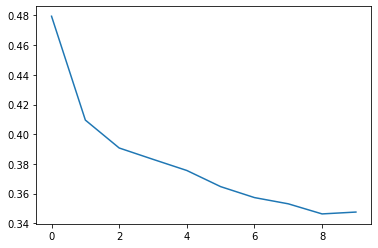

In [37]:
import matplotlib.pyplot as plt
#plt.plot(range(len(losses)), losses)
plt.plot(losses)

# State of the art model

To have a better model, we should add convolution layers of different kernel size, as in the paper of Yoon Kim 2014. 
We can use kernels of size 3,5, and 7 for instance. Create a new class for this model. 



In [ ]:
# TODO 

And finaly add dropout on the last layer hidden layer.  

# Mini-batch training

It is really faster to train the model with mini-batch. The issue is that the input sequences are not of the same size. As a workaround, we can write a function that create the tensor  for a mini-batch. This function needs: 
- a reference of the data (here texts)
- the maximum length of a sequence in the mini-batch
- a list of the indices of the sequences we want to put in the mini-batch

The function creates a tensor and fill it with the selected sequences, but : 
- if a sequence is shorter than the maximum length, we pad the sequence with zero values (fill the empty slots)
- if the sequence is longer, just truncate it. 
This function returns a tensor of dimensions (B,Lmax) to be the input of the embedding layer of our model. 




In [ ]:
# TODO 